# Import

In [1]:
import warnings
warnings.filterwarnings(action='once')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC #???????????????//
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, kendalltau

from astropy.table import QTable, join
from time import time

## Load required data

In [3]:
with open('./pickle/bounds.pk','rb') as f:
    bounds = pickle.load(f)
master_cat = pd.read_csv('./catdata/master_catalog_jan_2023.csv')
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [4]:
object_match_files = ['matches_delta006.pk','matches_delta005.pk','matches_delta004.pk']

In [5]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'

# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

## 19/02 Adding stars back in, and labelling stars and galaxies as 'non-gc'

In [57]:
for r in training_data[training_data['class']=='star'].index:
    training_data.loc[r,'class'] = 'non-gc'

In [60]:
for r in training_data[training_data['class']=='galaxy'].index:
    training_data.loc[r,'class'] = 'non-gc'

In [28]:
training_data

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106,-1.500999
1330,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156,-1.016001
1331,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163,-0.997000
1332,PA-N147-3,gc,19.910000,20.820999,0.004,0.004,8.542029,49.044243,402,101369,91,36,-0.910999


In [62]:
with open(f'./pickle/training_data/training_data_1902_with_stars.pk','wb') as f: #m[-4:-3] = the delta number
    pickle.dump(training_data,f)

# Training Data Generator

In [6]:
def load_cat(field): # change to match-case
    bounds = [50,100,150,200,235,257,279,320,360,406]
    for b in range(len(bounds)):
        if field <= bounds[b]:
            to_load = cat_files[b]
            break
    with open(f'./pickle/{to_load}','rb') as f:
        catalogue = pickle.load(f)
    return catalogue

In [7]:
# 23.01.26 18:29
def generate_training_data(matches, crowding=300) -> pd.DataFrame:
    cat = load_cat(1)
    
    columns = ['obj_id','class','i','g','di','dg','ra','dec','field','pdidx','rbcidx','nearby']
    values = []
    object_ids = []
    
    #TEMP
    crowded_objects = []
    
    
    for field in matches: # iterate through each field ID
        working_field = matches[field] # take the list of matches e.g. working_field = [(166727, 2642), (159637, 2646)]
        if field not in cat: # load the correct catalogue
            cat = load_cat(field)
        for m in working_field: # iterate through each match (a tuple) and grab values from catalogues
            
            if m[2] > crowding: # testing
                crowded_objects.append(m[1:])
                continue
            
            obj_id = master_cat.loc[m[1]].ID
            class_ = master_cat.loc[m[1]].CLASS
            
            if obj_id in object_ids: continue # if we've already added the object then skip
            else: object_ids.append(obj_id)   # else add it to the list of ids
            
            if class_ == 1: class_str = 'gc' # convert class numbers into strings
            elif class_ == 4: class_str = 'galaxy'
            elif class_ == 6: class_str = 'star'
            else: continue # skip non-gc/gal/stars
            
            # collect required data
            row = cat[field][m[0]]
            ra = row['RA']
            dec = row['Dec']
            g = row['g']
            i = row['i']
            dg = row['dg']
            di = row['di']
            
            values.append([obj_id,class_str,i,g,di,dg,ra,dec,field,m[0],m[1],m[2]])
    
    training_data_dict = dict(zip(columns,zip(*values))) # zip values and columns together into a dict (columns as keys)
    training_data_df = pd.DataFrame(training_data_dict) # put into pd Dataframe
    return training_data_df, crowded_objects

In [8]:
#generate training data for a range of crowding, and delta, values
object_match_files = ['matches_delta006.pk','matches_delta005.pk','matches_delta004.pk','matches_delta003.pk']
#TEMP
object_match_files = ['matches_delta005_0502.pk']

for m in object_match_files:
    obj_mat = pickle.load(open(f'./pickle/matches/{m}','rb'))
    #training_data = {}
    for c in crowding_test_values[0:1]:
        print(c)
        training_data, _ = generate_training_data(obj_mat, crowding=c)
    with open(f'./pickle/training_data/training_data_0502.pk','wb') as f: #m[-4:-3] = the delta number
        pickle.dump(training_data,f)

C:\Users\jwarn\AppData\Local\Temp\ipykernel_24432\3899603297.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/matches/matches_delta005_0502.pk'>
  obj_mat = pickle.load(open(f'./pickle/matches/{m}','rb'))


NameError: name 'crowding_test_values' is not defined

To filter the training data for different crowding values, we can simply iterate back through the list of matches and remove the entries that are outside the threshold, instead of having to re-generate the data every time.

# Statistics

In [7]:
def calc_correlations(pred,true):
    correlations = {}
    correlations['mse'] = mean_squared_error(pred,true)
    correlations['ktau'] = kendalltau(pred,true)[0]
    correlations['pval-ktau'] = kendalltau(pred,true)[1]
    correlations['pearsonr'] = pearsonr(pred,true)[0]
    correlations['pval-pearsonr'] = pearsonr(pred,true)[1]
    correlations['r2'] = r2_score(true, pred)
    return correlations

In [8]:
def pretty_corr(c): # pretty print output from calc_correlations()
    print(f"""
    Mean squared error (RMS): \t{c['mse']:.5f}\t({(c['mse']**.5):.5})
    Kendall Tau: \t\t{c['ktau']:.5}
    \tKtau p-value: \t\t{c['pval-ktau']:.5}
    Pearson's r: \t\t{c['pearsonr']:.5}
    \tPearson's r p-value: \t{c['pval-pearsonr']:.5}
    Coef. of determination \t{c['r2']:.5}
    """)

# Random Forest

In [9]:
def ranfor(df,train_size=0.8,n_estimators=50,criterion='gini',features=['i','g','i-g'], max_depth=None, max_leaf_nodes=None, min_samples_leaf=1, stats=False, scale=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split the data
    if scale:
        # scale the data
        scaler = preprocessing.StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size) # X
    # train the regressor model
    ran_for_class = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                    criterion=criterion, max_leaf_nodes=max_leaf_nodes,
                                    min_samples_leaf=min_samples_leaf                                        
                                   ).fit(X_train,y_train)
    train_pred = ran_for_class.predict(X_train)
    test_pred = ran_for_class.predict(X_test)
    
    acc = ran_for_class.score(X_test,y_test)
    
    true = y_test.to_numpy()
    if stats:
        return ran_for_class, test_pred, y_test, train_pred, y_train
    else: return ran_for_class

In [10]:
def rf_pred(field,train,crowding=250,n_estimators=50,max_depth=None,max_leaf_nodes=None,min_samples_leaf=1,features=['i','g','i-g'],scale=False):
    training_data_ = train[train['nearby'] <= crowding]
    cat = load_cat(field)[field]
    
    # drop rows with high delta g/i values
    cat_d = cat[cat['dg']+cat['di'] < 0.05]
    # drop stars & saturated points
    cat_candidate = cat_d[(cat_d['ig'] == 1) & (cat_d['ii'] == 1)]
    cat_candidate['i-g'] = cat_candidate['i']-cat_candidate['g']
    
    X = cat_candidate[['i','g','i-g']]
    X = X.to_pandas()
    if scale:
        X_scaled = preprocessing.StandardScaler().fit(X).transform(X)
        res = ranfor(training_data_,train_size=0.8,n_estimators=n_estimators,criterion='gini',
                     features=features, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                     min_samples_leaf=1, scale=True).predict(X_scaled)
    else:
        res = ranfor(training_data_,train_size=0.8,n_estimators=n_estimators,criterion='gini',
                     features=features, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                     min_samples_leaf=1).predict(X)
    
    cat_pred = cat_candidate[['RA','Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','field']]
    cat_pred['pred'] = res
    return cat_pred

# SVC

In [11]:
def svc_class(df,train_size=0.8,max_iter=1000,loss='squared_hinge',features=['i','g'], stats=False, scale=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split the data
    if scale:
        # scale the data
        scaler = preprocessing.StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size) # X
    # train the regressor model
    svc_classifier = LinearSVC(dual=False,C=0.8,max_iter=max_iter).fit(X_train,y_train)
    pred = svc_classifier.predict(X_test)
    
    true = y_test.to_numpy()
    if stats:
        return svc_classifier, pred, true
    else: return svc_classifier

# MLP

Has trouble with suddenly predicting all the same value for every object

In [12]:
def mlp_class(df,train_size=0.8,hidden_layer_sizes=(10,),activation='relu',alpha=0.0001,max_iter=500,features=['i','g'], stats=False, scale=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split the data
    if scale:
        # scale the data
        scaler = preprocessing.StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size) # X
    # train the regressor model
    mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                   activation=activation, alpha=alpha, max_iter=max_iter,
                                   learning_rate='adaptive',early_stopping=True,
                                  ).fit(X_train,y_train)
    pred = mlp_classifier.predict(X_test)
    true = y_test.to_numpy()
    if stats:
        return mlp_classifier, pred, true
    else: return mlp_classifier

### Random Forest Parameter Varying Functions

In [13]:
def rf_stats_append(stats, train_test_values, n):
    for i in [0,2]:
        tn, fp, fn, tp = confusion_matrix(train_test_values[i],train_test_values[i+1],labels=['non-gc','gc']).ravel()
        stats[n]['rec'][i>>1].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        stats[n]['acc'][i>>1].append( (tp+tn)/(tn+fp+fn+tp) ) # fraction of correctly identified objects
        stats[n]['prec'][i>>1].append( tp/(tp+fp) ) # fraction of correctly identified GCs, out of what were thought to be GCs    
    return stats

In [14]:
def rf_vary_trees(n_estimators_range: range, iterations: int, max_leaf_nodes=None, max_depth=None,min_samples_leaf=1, features=['i','g','i-g']) -> dict:
    stats = {}
    for n in n_estimators_range:
        print(f'calculating for {n} trees...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = ranfor(training_data,n_estimators=n,features=features,min_samples_leaf=min_samples_leaf,
                                   max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, stats=True)[1:]
            stats = rf_stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

def rf_vary_max_leaf_nodes(max_leaf_range: range, iterations: int, n_estimators=50, max_depth=None,min_samples_leaf=1, features=['i','g','i-g']) -> dict:
    stats = {}
    for n in max_leaf_range:
        print(f'calculating max leaf nodes {n}...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = ranfor(training_data,n_estimators=n_estimators,features=features,min_samples_leaf=min_samples_leaf,
                                   max_depth=max_depth, max_leaf_nodes=n, stats=True)[1:]
            stats = rf_stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

def rf_vary_min_samples_leaf(min_samples_range: list, iterations: int, n_estimators=50, max_leaf_nodes=None, max_depth=None, features=['i','g','i-g']) -> dict:
    stats = {}
    for n in min_samples_range:
        print(f'calculating min samples {n}...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = ranfor(training_data,n_estimators=n_estimators,features=features,
                                   max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=n, stats=True)[1:]
            stats = rf_stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

def rf_vary_max_depth(max_depth_range: range, iterations: int, n_estimators=50, max_leaf_nodes=None,min_samples_leaf=1, features=['i','g','i-g']) -> dict:
    stats = {}
    for n in max_depth_range:
        print(f'calculating max depth {n}...')
        stats[n] = {'acc':[[],[]],'prec':[[],[]],'rec':[[],[]]} # ([test],[train])
        for i in range(iterations):
            train_test_values = ranfor(training_data,n_estimators=n_estimators,features=features,min_samples_leaf=min_samples_leaf,
                                   max_depth=n, max_leaf_nodes=max_leaf_nodes, stats=True)[1:]
            stats = rf_stats_append(stats,train_test_values,n)
        for k in stats[n]:
            stats[n][k][0] = sum(stats[n][k][0])/iterations
            stats[n][k][1] = sum(stats[n][k][1])/iterations
    return stats

In [15]:
def plot_stats(stats: dict, xlabel: str):
    keys_ = stats.keys()
    acc = [stats[k]['acc'] for k in keys_]
    prec = [stats[k]['prec'] for k in keys_]
    rec = [stats[k]['rec'] for k in keys_]
    plt.plot(keys_, [a[0] for a in acc], label='accuracy (test)', c='#4888e8')
    plt.plot(keys_, [a[1] for a in acc], label='accuracy (train)', c='#025ee8')
    plt.plot(keys_, [p[0] for p in prec], label='precision (test)', c='#c94ef2')
    plt.plot(keys_, [p[1] for p in prec], label='precision (train)', c='#9902cc')
    plt.plot(keys_, [r[0] for r in rec], label='recall (test)', c='#fa6e64')
    plt.plot(keys_, [r[1] for r in rec], label='recall (train)', c='#d90e00')
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.legend()
    plt.show()

# Read region files back in
... and match them to the original CAT file for adding back to the training set  
started working on 20/02

In [16]:
# reads a region file and returns a list of coordinates for every point listed within
# note: the path parameter must be the path starting in the root directory (e.g. path='ds9_regions/folder/region.reg')
#      otherwise, the field parameter will look for the file 'ds9_regions/predictions/FIELD_predictions.reg'
# note: region file must be formatted with the first two lines defining the settings and coordinate system,
#       with the third line beginning the list of circle(x,y) or point(x,y)
def read_reg(field: int, path=None) -> list:
    if path is None:
        path = f'ds9_regions/predictions/{field}_predictions.reg'
    try:
        with open(path,'r') as f:
            reg_file_lines = f.readlines()[2:] # skip the first two lines
    except FileNotFoundError:
        print("Please enter a full path to the file from the current directory, or choose a field that has a predictions region file.")
        return 0
    
    ret = []
    for i in range(len(reg_file_lines)):
        coords = reg_file_lines[i].split('(')[1].split(',')[0:2] # split at the first open bracket, split along, commas, choose the first two values (the coordinates)
        ra = float(coords[0])
        dec = float(coords[1])
        ret.append((ra,dec))
    return ret

In [17]:
# takes a list of coordinates and field, and returns a list of values to add to training data
def get_data_from_coords(field: int, coords: list) -> list:
    cat = load_cat(field)[field]
    ret = []
    for c in coords:
        row = cat[(cat['RA']==c[0]) & (cat['Dec']==c[1])][0]
        i, g = row['i'], row['g']
        di, dg = row['di'], row['dg']
        i_g = i-g
        ra, dec = c
        # pdidx = # need to find a way of extracting the pandas index
        vals = (i,g,di,dg,ra,dec,field,i_g) # values for relevant columns in training
        ret.append(vals)
    return ret

In [18]:
# takes the training dataset and a list of values to add to it and returns a new dataframe with the added values
def add_nongc_to_training(train_df: pd.DataFrame, vals: list, nongc_class='galaxy') -> pd.DataFrame:
    # make dataframe from values
    columns = ['i','g','di','dg','ra','dec','field','i-g']
    add_df = pd.DataFrame(vals,columns=columns)
    add_df['obj_id'] = 'none'
    add_df['class'] = nongc_class
    add_df['pdidx'] = 0
    add_df['rbcidx'] = 0
    add_df['nearby'] = 0
    
    new_df = pd.concat([train_df, add_df],ignore_index=True, verify_integrity=True,copy=False)
    return new_df

In [19]:
def update_training_data(field:int, path=None, train_df=training_data, nongc_class='galaxy') -> pd.DataFrame:
    coords = read_reg(field, path=path)
    vals = get_data_from_coords(field,coords)
    new_training_data = add_nongc_to_training(train_df,vals,nongc_class=nongc_class)
    return new_training_data

### Testing loading new train data from regions

In [118]:
training_data

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,none,galaxy,22.535000,23.332001,0.027,0.021,14.018342,30.891619,35,0,0,0,-0.797001
1757,none,galaxy,22.490000,23.375999,0.025,0.021,14.089608,30.940580,35,0,0,0,-0.886000
1758,none,galaxy,22.539000,23.372000,0.027,0.021,14.061517,30.956402,35,0,0,0,-0.833000
1759,none,galaxy,22.495001,23.396000,0.025,0.021,14.104804,31.012040,35,0,0,0,-0.900999


In [151]:
new_train = update_training_data(21)

In [152]:
new_train

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,none,galaxy,22.718000,23.495001,0.028,0.020,11.801250,30.054356,21,0,0,0,-0.777000
2208,none,galaxy,22.591000,23.504999,0.026,0.021,11.916008,29.841837,21,0,0,0,-0.914000
2209,none,galaxy,22.568001,23.559999,0.025,0.021,11.916621,29.989470,21,0,0,0,-0.991999
2210,none,galaxy,22.615999,23.528000,0.026,0.021,11.903784,29.837309,21,0,0,0,-0.912001


In [140]:
# save new training data
field = 148
with open(f'./pickle/training_data/temp/train_plus_{field}.pk','wb') as f:
    pickle.dump(new_train,f)

## Predictions

In [156]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'

# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

In [153]:
training_data = new_train

In [165]:
training_data[training_data['class']=='galaxy']

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001
5,C40,galaxy,20.737000,21.759001,0.007,0.006,13.526137,29.921856,20,157983,2549,12,-1.022001
6,C26,galaxy,19.025000,20.422001,0.002,0.003,11.004237,30.700373,22,35300,1454,19,-1.397001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,C68,galaxy,18.152000,19.642000,0.001,0.002,23.524841,45.725613,342,51513,2639,23,-1.490000
1310,C56,galaxy,20.915001,21.892000,0.007,0.007,19.399963,46.188301,351,61998,2609,18,-0.976999
1311,C55,galaxy,18.355000,19.791000,0.001,0.002,18.623255,46.101940,351,92425,2606,19,-1.436001
1314,2M013,galaxy,14.828000,18.309000,0.001,0.001,12.981854,47.123074,375,153512,2542,19,-3.481000


In [157]:
# gather performance stats for random forest model

rf_classifier, test_pred, test_true, train_pred, train_true = ranfor(training_data,n_estimators=50,max_depth=9, max_leaf_nodes=15,min_samples_leaf=10, stats=True)

tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tn+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'Test Scores:\nrecall:{recall}\nprecision:{precision}\naccuracy:{accuracy}\n')

tn, fp, fn, tp = confusion_matrix(train_true,train_pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tn+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'Train Scores:\nrecall:{recall}\nprecision:{precision}\naccuracy:{accuracy}\n')

Test Scores:
recall:0.8538461538461538
precision:0.8473282442748091
accuracy:0.8539325842696629

Train Scores:
recall:0.8676470588235294
precision:0.8660550458715597
accuracy:0.8641049671977507



In [92]:
field = 80
#RF
predictions_rf = rf_pred(field,training_data_nostar,crowding=250,n_estimators=50,max_depth=8, max_leaf_nodes=7,min_samples_leaf=10)
with open(f'pickle/temp/predictionsf{field}.pk','wb') as f:
    pickle.dump(predictions_rf,f)
len(predictions_rf[predictions_rf['pred'] == 'gc'])

NameError: name 'training_data_nostar' is not defined

### 17/02/2023 Hyperparameter tuning

In [29]:
list(range(10))+list(range(20,30))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

In [33]:
trees_range = range(10,60,4)
depth_range = range(2,25)
leaf_range = list(range(2,25))
min_samples_range = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 32, 36, 48]

In [34]:
rfstats_leaf = rf_vary_max_leaf_nodes(leaf_range, 100, max_depth=9, min_samples_leaf=8)

calculating max leaf nodes 2...
calculating max leaf nodes 3...
calculating max leaf nodes 4...
calculating max leaf nodes 5...
calculating max leaf nodes 6...
calculating max leaf nodes 7...
calculating max leaf nodes 8...
calculating max leaf nodes 9...
calculating max leaf nodes 10...
calculating max leaf nodes 11...
calculating max leaf nodes 12...
calculating max leaf nodes 13...
calculating max leaf nodes 14...


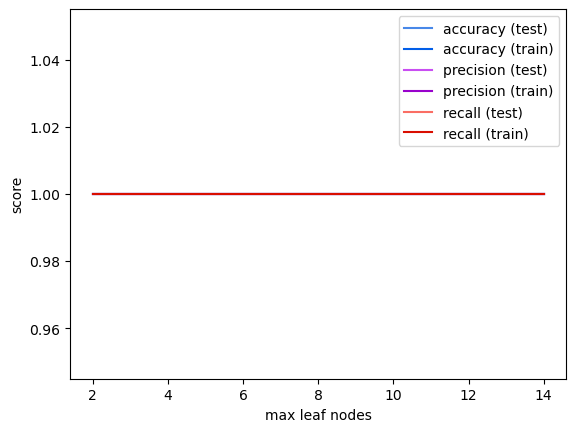

In [35]:
plot_stats(rfstats_leaf,'max leaf nodes')

In [108]:
rfstats_trees = rf_vary_trees(trees_range,200, max_depth=9, max_leaf_nodes=10,min_samples_leaf=10)
rfstats_depth = rf_vary_max_depth(depth_range, 200, max_leaf_nodes=10,min_samples_leaf=10)
rfstats_min_samples = rf_vary_min_samples_leaf(min_samples_range,200, max_depth=9, max_leaf_nodes=10)

calculating for 10 trees...
calculating for 14 trees...
calculating for 18 trees...
calculating for 22 trees...
calculating for 26 trees...
calculating for 30 trees...
calculating for 34 trees...
calculating for 38 trees...
calculating for 42 trees...
calculating for 46 trees...
calculating for 50 trees...
calculating for 54 trees...
calculating for 58 trees...
calculating max depth 2...
calculating max depth 3...
calculating max depth 4...
calculating max depth 5...
calculating max depth 6...
calculating max depth 7...
calculating max depth 8...
calculating max depth 9...
calculating max depth 10...
calculating max depth 11...
calculating max depth 12...
calculating max depth 13...
calculating max depth 14...
calculating max depth 15...
calculating max depth 16...
calculating max depth 17...
calculating max depth 18...
calculating max depth 19...
calculating max depth 20...
calculating max depth 21...
calculating max depth 22...
calculating max depth 23...
calculating max depth 24...


ValueError: At least one label specified must be in y_true

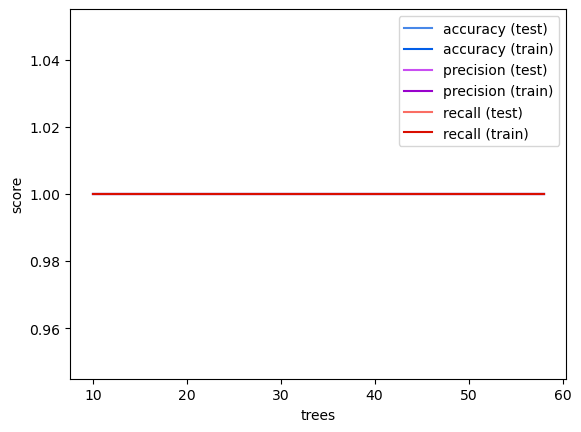

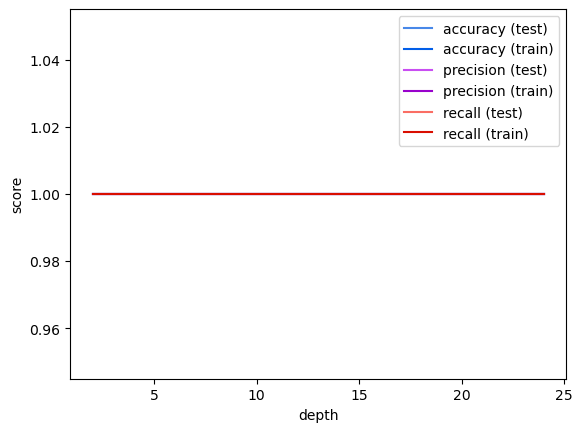

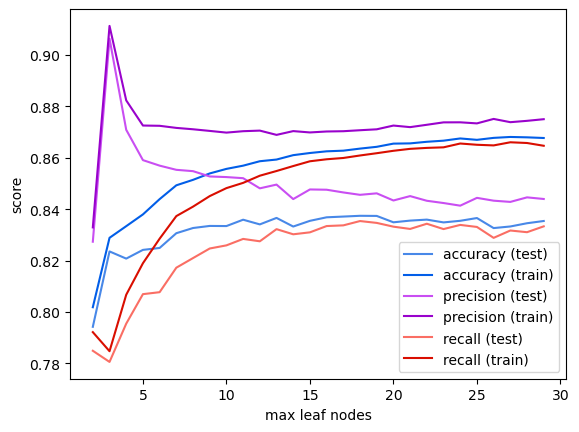

NameError: name 'rfstats_min_samples' is not defined

In [110]:
plot_stats(rfstats_trees,'trees')
plot_stats(rfstats_depth,'depth')
plot_stats(rfstats_min_samples,'min_samples')

### 16/02/2023

In [25]:
#load 
with open('./pickle/temp/rfstats_trees3.pk','rb') as f:
    rfstats_trees = pickle.load(f)
with open('./pickle/temp/rfstats_depth3.pk','rb') as f:
    rfstats_depth = pickle.load(f)
with open('./pickle/temp/rfstats_leaf3.pk','rb') as f:
    rfstats_leaf = pickle.load(f)
with open('./pickle/temp/rfstats_min_samples3.pk','rb') as f:
    rfstats_min_samples = pickle.load(f)

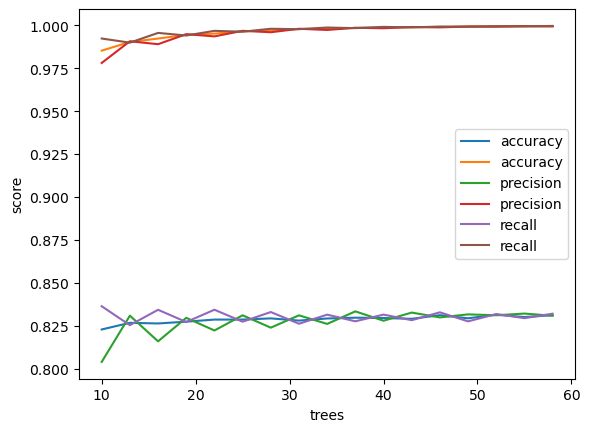

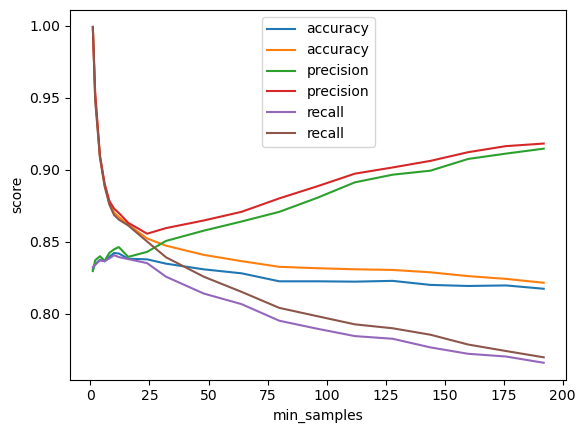

In [30]:
plot_stats(rfstats_trees,'trees')
plot_stats(rfstats_min_samples,'min_samples')

In [43]:
# min samples calc

In [45]:

min_samples_range = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 32, 36, 48, 64, 80]
rfstats_min_samples = rf_vary_min_samples_leaf(min_samples_range, 400)

calculating min samples 1...
calculating min samples 2...
calculating min samples 3...
calculating min samples 4...
calculating min samples 5...
calculating min samples 6...
calculating min samples 8...
calculating min samples 10...
calculating min samples 12...
calculating min samples 14...
calculating min samples 16...
calculating min samples 20...
calculating min samples 24...
calculating min samples 32...
calculating min samples 36...
calculating min samples 48...
calculating min samples 64...
calculating min samples 80...


In [31]:
# min samples plot

In [32]:
trees_range = range(10,60,3)
depth_range = range(2,25)
leaf_range = range(2,165,4)
min_samples_range = [1, 2, 4, 6, 8, 10, 12, 16, 24, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192]

In [47]:
rfstats_min_samples_test = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_min_samples_test:
    rfstats_min_samples_test[k] = [rfstats_min_samples[n][k][0] for n in rfstats_min_samples]
rfstats_min_samples_train = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_min_samples_train:
    rfstats_min_samples_train[k] = [rfstats_min_samples[n][k][1] for n in rfstats_min_samples]

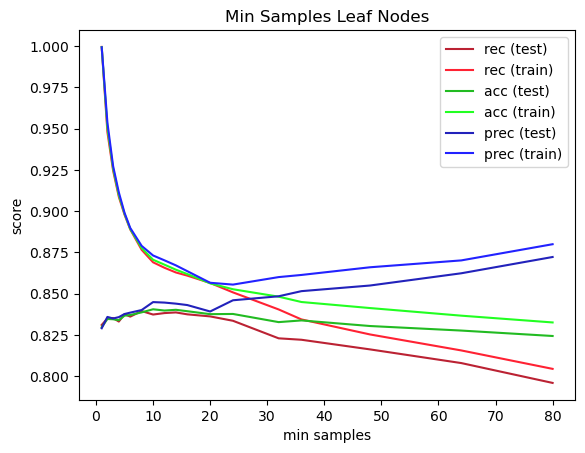

In [48]:
plt.plot(min_samples_range,rfstats_min_samples_test['rec'],c='#B23',label='rec (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['rec'],c='#F23',label='rec (train)')
plt.plot(min_samples_range,rfstats_min_samples_test['acc'],c='#2B2',label='acc (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['acc'],c='#2F2',label='acc (train)')
plt.plot(min_samples_range,rfstats_min_samples_test['prec'],c='#22B',label='prec (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['prec'],c='#22F',label='prec (train)')
plt.xlabel('min samples')
plt.ylabel('score')
plt.title('Min Samples Leaf Nodes')
plt.legend()
#plt.ylim([0.75,1])
plt.show()

### 15/02/2023

In [20]:
# select most recent training data
train_file = 'training_data_0802.pk'

In [21]:
# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)
#training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))
training_data_nostar = training_data[training_data['class'] != 'star']

In [22]:
training_data_nostar['i-g'] = training_data_nostar['i']-training_data_nostar['g']

C:\Users\jwarn\AppData\Local\Temp\ipykernel_20648\1434339991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_nostar['i-g'] = training_data_nostar['i']-training_data_nostar['g']


In [23]:
len(range(1,200,5))

40

In [24]:
trees_range = range(10,60,3)
depth_range = range(2,25)
leaf_range = range(2,165,4)
min_samples_range = [1, 2, 4, 6, 8, 10, 12, 16, 24, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192]

In [177]:
rfstats_min_samples = rf_vary_min_samples_leaf(min_samples_range, 1000)
rfstats_trees = rf_vary_trees(trees_range, 1000)
rfstats_depth = rf_vary_max_depth(depth_range, 1000)
rfstats_leaf = rf_vary_max_leaf_nodes(leaf_range, 1000)

calculating min samples 1...
calculating min samples 2...
calculating min samples 4...
calculating min samples 6...
calculating min samples 8...
calculating min samples 10...
calculating min samples 12...
calculating min samples 16...
calculating min samples 24...
calculating min samples 32...
calculating min samples 48...
calculating min samples 64...
calculating min samples 80...
calculating min samples 96...
calculating min samples 112...
calculating min samples 128...
calculating min samples 144...
calculating min samples 160...
calculating min samples 176...
calculating min samples 192...
calculating for 10 trees...
calculating for 13 trees...
calculating for 16 trees...
calculating for 19 trees...
calculating for 22 trees...
calculating for 25 trees...
calculating for 28 trees...
calculating for 31 trees...
calculating for 34 trees...
calculating for 37 trees...
calculating for 40 trees...
calculating for 43 trees...
calculating for 46 trees...
calculating for 49 trees...
calcula

**.pk - 14/02*  
**2.pk - 15/02 (incl i-g as a feature now)*  
**3.pk - 15/02 "" "" (more iterations)*

In [178]:
#save
with open('./pickle/temp/rfstats_trees3.pk','wb') as f:
    pickle.dump(rfstats_trees,f)
with open('./pickle/temp/rfstats_depth3.pk','wb') as f:
    pickle.dump(rfstats_depth,f)
with open('./pickle/temp/rfstats_leaf3.pk','wb') as f:
    pickle.dump(rfstats_leaf,f)
with open('./pickle/temp/rfstats_min_samples3.pk','wb') as f:
    pickle.dump(rfstats_min_samples,f)

In [179]:
rfstats_min_samples_test = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_min_samples_test:
    rfstats_min_samples_test[k] = [rfstats_min_samples[n][k][0] for n in rfstats_min_samples]
rfstats_min_samples_train = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_min_samples_train:
    rfstats_min_samples_train[k] = [rfstats_min_samples[n][k][1] for n in rfstats_min_samples]

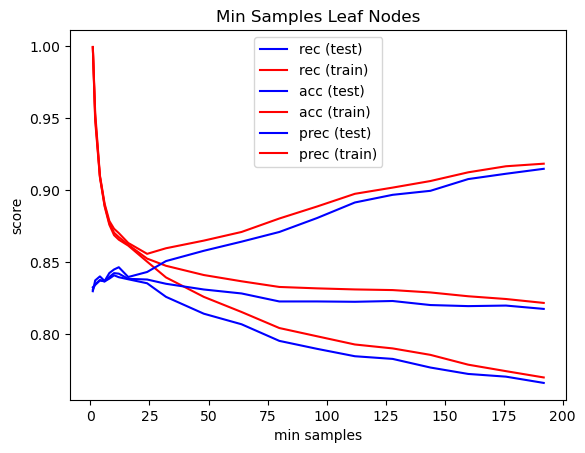

In [185]:
plt.plot(min_samples_range,rfstats_min_samples_test['rec'],c='b',label='rec (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['rec'],c='r',label='rec (train)')
plt.plot(min_samples_range,rfstats_min_samples_test['acc'],c='b',label='acc (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['acc'],c='r',label='acc (train)')
plt.plot(min_samples_range,rfstats_min_samples_test['prec'],c='b',label='prec (test)')
plt.plot(min_samples_range,rfstats_min_samples_train['prec'],c='r',label='prec (train)')
plt.xlabel('min samples')
plt.ylabel('score')
plt.title('Min Samples Leaf Nodes')
plt.legend()
#plt.ylim([0.75,1])
plt.show()

In [182]:
rfstats_leaf_test = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_leaf_test:
    rfstats_leaf_test[k] = [rfstats_leaf[n][k][0] for n in rfstats_leaf]
rfstats_leaf_train = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_leaf_train:
    rfstats_leaf_train[k] = [rfstats_leaf[n][k][1] for n in rfstats_leaf]

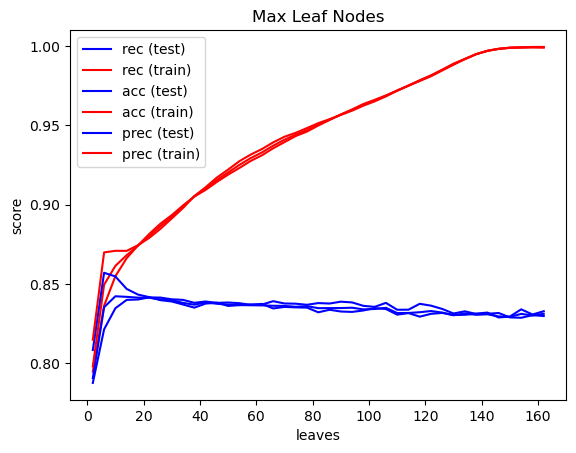

In [183]:
plt.plot(leaf_range,rfstats_leaf_test['rec'],c='b',label='rec (test)')
plt.plot(leaf_range,rfstats_leaf_train['rec'],c='r',label='rec (train)')
plt.plot(leaf_range,rfstats_leaf_test['acc'],c='b',label='acc (test)')
plt.plot(leaf_range,rfstats_leaf_train['acc'],c='r',label='acc (train)')
plt.plot(leaf_range,rfstats_leaf_test['prec'],c='b',label='prec (test)')
plt.plot(leaf_range,rfstats_leaf_train['prec'],c='r',label='prec (train)')
plt.xlabel('leaves')
plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.legend()
#plt.ylim([0.75,1])
plt.show()

### 13/02/2023 Optimising hyperparameters of Random Forest

In [11]:
# select most recent training data
train_file = 'training_data_0802.pk'

In [12]:
# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)
#training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))
training_data_nostar = training_data[training_data['class'] != 'star']

In [15]:
training_data_nostar['i-g'] = training_data_nostar['i']-training_data_nostar['g']

C:\Users\jwarn\AppData\Local\Temp\ipykernel_12140\1434339991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_nostar['i-g'] = training_data_nostar['i']-training_data_nostar['g']


In [16]:
training_data_nostar

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106,-1.500999
2003,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156,-1.016001
2004,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163,-0.997000
2005,PA-N147-3,gc,19.910000,20.820999,0.004,0.004,8.542029,49.044243,402,101369,91,36,-0.910999


In [167]:
# gather performance stats for random forest model

rf_classifier, test_pred, test_true, train_pred, train_true = ranfor(training_data_nostar,n_estimators=50,max_depth=8, max_leaf_nodes=25,min_samples_leaf=100, stats=True)

tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'Test Scores:\nrecall:{recall}\nprecision:{precision}\naccuracy:{accuracy}\n')

tn, fp, fn, tp = confusion_matrix(train_true,train_pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'Train Scores:\nrecall:{recall}\nprecision:{precision}\naccuracy:{accuracy}\n')

Test Scores:
recall:0.8692307692307693
precision:0.773972602739726
accuracy:0.7789855072463768

Train Scores:
recall:0.8851224105461394
precision:0.8173913043478261
accuracy:0.8047016274864376



In [136]:
max_depth_range = range(2,9,2)
iterations = range(5)
stats = {}

for n in max_depth_range:
    stats[n] = {'acc':[],'prec':[],'rec':[]}
    for i in iterations:
        _, test_pred, test_true, train_pred, train_true = ranfor(training_data_nostar,n_estimators=50,max_depth=n, max_leaf_nodes=3,  stats=True)
        tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()
        stats[n]['rec'].append( tp/(tp+fn) ) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
        stats[n]['acc'].append( (tp+tn)/(tn+fp+fn+tp) ) # fraction of correctly identified objects
        stats[n]['prec'].append( tp/(tp+fp) ) # fraction of correctly identified GCs, out of what were thought to be GCs
    for k in stats[n]:
        stats[n][k] = sum(stats[n][k])/len(iterations)

NameError: name 'true' is not defined

In [79]:
trees_range = range(10,150,5)
depth_range = range(2,41)
leaf_range = range(10,200,5)

In [74]:
rfstats_trees = rf_vary_trees(range(10,150,5), 300)
rfstats_depth = rf_vary_max_depth(range(2,41), 300)
rfstats_leaf = rf_vary_max_leaf_nodes(range(10,200,5), 300)

calculating for 10 trees...
calculating for 15 trees...
calculating for 20 trees...
calculating for 25 trees...
calculating for 30 trees...
calculating for 35 trees...
calculating for 40 trees...
calculating for 45 trees...
calculating for 50 trees...
calculating for 55 trees...
calculating for 60 trees...
calculating for 65 trees...
calculating for 70 trees...
calculating for 75 trees...
calculating for 80 trees...
calculating for 85 trees...
calculating for 90 trees...
calculating for 95 trees...
calculating for 100 trees...
calculating for 105 trees...
calculating for 110 trees...
calculating for 115 trees...
calculating for 120 trees...
calculating for 125 trees...
calculating for 130 trees...
calculating for 135 trees...
calculating for 140 trees...
calculating for 145 trees...
calculating max depth 2...
calculating max depth 3...
calculating max depth 4...
calculating max depth 5...
calculating max depth 6...
calculating max depth 7...
calculating max depth 8...
calculating max d

**.pk - 14/02*  
**2.pk - 15/02 (incl i-g as a feature now)*

In [75]:
with open('./pickle/temp/rfstats_trees2.pk','wb') as f:
    pickle.dump(rfstats_trees,f)
with open('./pickle/temp/rfstats_depth2.pk','wb') as f:
    pickle.dump(rfstats_depth,f)
with open('./pickle/temp/rfstats_leaf2.pk','wb') as f:
    pickle.dump(rfstats_leaf,f)

In [112]:
rfstats_leaf_test = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_leaf_test:
    rfstats_leaf_test[k] = [rfstats_leaf[n][k][0] for n in rfstats_leaf]
rfstats_leaf_train = {'acc':[],'prec':[],'rec':[]}
for k in rfstats_leaf_train:
    rfstats_leaf_train[k] = [rfstats_leaf[n][k][1] for n in rfstats_leaf]

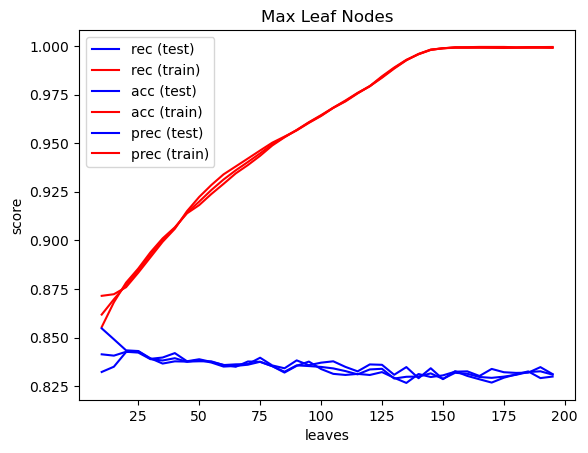

In [113]:
plt.plot(leaf_range,rfstats_leaf_test['rec'],c='b',label='rec (test)')
plt.plot(leaf_range,rfstats_leaf_train['rec'],c='r',label='rec (train)')
plt.plot(leaf_range,rfstats_leaf_test['acc'],c='b',label='acc (test)')
plt.plot(leaf_range,rfstats_leaf_train['acc'],c='r',label='acc (train)')
plt.plot(leaf_range,rfstats_leaf_test['prec'],c='b',label='prec (test)')
plt.plot(leaf_range,rfstats_leaf_train['prec'],c='r',label='prec (train)')
plt.xlabel('leaves')
plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.legend()
#plt.ylim([0.75,1])
plt.show()

In [95]:
def make_predictions():
    field = 222
    #RF
    predictions_rf = rf_pred(field,training_data_nostar,crowding=300)
    #with open(f'pickle/temp/predictionsf{field}.pk','wb') as f:
        #pickle.dump(predictions,f)
    len(predictions_rf[predictions_rf['pred'] == 'gc'])
    with open(f'pickle/temp/predictionsf222_0802test.pk','wb') as f:
        pickle.dump(predictions,f)

### 08/02/2023 Predictions and Training

Automate training

In [14]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [17]:
training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))
training_data_nostar = training_data[training_data['class'] != 'star']

C:\Users\jwarn\AppData\Local\Temp\ipykernel_19844\3009024223.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/training_data/training_data_0802.pk'>
  training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))


In [178]:
#RF

rf_classifier, pred, true = ranfor(training_data_nostar,n_estimators=50,max_depth=5, max_leaf_nodes=3,  stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'recall:{recall}\nprecision:{precision}\naccuracy:{accuracy}')

recall:0.848
precision:0.7851851851851852
accuracy:0.8346153846153846


In [14]:
field = 222
#RF
predictions_rf = rf_pred(field,training_data_nostar,crowding=300)
#with open(f'pickle/temp/predictionsf{field}.pk','wb') as f:
    #pickle.dump(predictions,f)
len(predictions_rf[predictions_rf['pred'] == 'gc'])

NameError: name 'training_data_nostar' is not defined

In [198]:
#SVC

svc_classifier, pred, true = svc_class(training_data_nostar, stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn)
recall

0.6946107784431138

#MLP

mlp_classifier, pred, true = mlp_class(training_data_nostar,hidden_layer_sizes=(20,),activation='logistic',alpha=0.0001, stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'recall:{recall}\nprecision:{precision}\naccuracy:{accuracy}')

In [223]:
with open(f'pickle/temp/predictionsf222_0802test.pk','wb') as f:
    pickle.dump(predictions,f)

#### 05/02/2023

In [140]:
x = range(1,300,1)

In [148]:
y = [ len(training_data[training_data['nearby'] <= i]) for i in x ]

In [146]:
y = [ len(training_data_nostar[training_data_nostar['nearby'] <= i]) for i in x ]

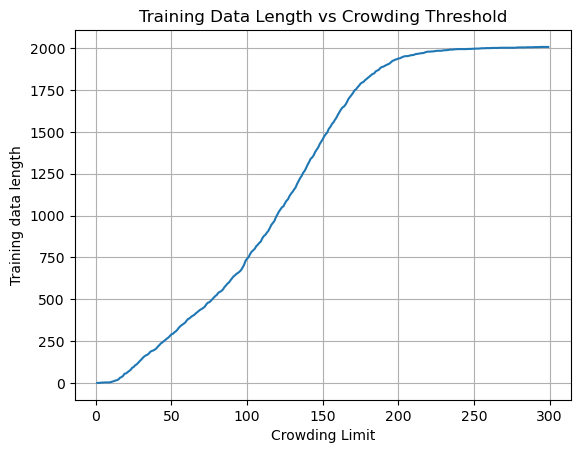

In [149]:
plt.plot(x,y)
plt.xlabel('Crowding Limit')
plt.ylabel('Training data length')
plt.title('Training Data Length vs Crowding Threshold')
plt.grid()

In [14]:
train_file = 'training_data_0502.pk'

In [11]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [15]:
training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))

In [16]:
training_data_nostar = training_data[training_data['class'] != 'star']

In [17]:
training_data_nostar

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby
0,HM33-A,gc,21.163000,22.052999,0.009,0.009,23.924183,28.820591,5,39696,2647,49
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2223,FJJ-IV,gc,18.417999,19.346001,0.002,0.002,9.801158,48.380100,398,168491,369,167
2224,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106
2225,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156
2226,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163


In [105]:
stats = ranfor(training_data_nostar,train_size=0.8, n_estimators=5, stats=True, max_depth=8, max_leaf_nodes=5)
stats[2]

0.7737704918032787

In [107]:
tn, fp, fn, tp = confusion_matrix(stats[1],stats[0],labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn)
recall

0.75

In [389]:
rf_model  = ranfor(training_data_star, n_estimators=100)

#### Testing filtering the catalogues for prediction

In [205]:
cat = load_cat(26)[26].to_pandas()

In [213]:
cat_d = cat[cat['dg']+cat['di'] < 0.05]

In [231]:
cat_candidate = cat_d[~((cat_d['ig'] == -1) | (cat_d['ii'] == -1) | (cat_d['ig'] == -9) | (cat_d['ii'] == -9))] # drop stars & saturated points

#### Testing making predictions

In [83]:
test_ = predictions[~((predictions['ig'] == -1) | (predictions['ii'] == -1) )]

In [85]:
len(test_[test_['pred']=='gc'])

2487

In [236]:
field = 208
#RF
predictions = rf_pred(field,training_data_nostar,crowding=300)
with open(f'pickle/temp/predictionsf{field}1102.pk','wb') as f:
    pickle.dump(predictions,f)
len(predictions[predictions['pred'] == 'gc'])

Loading cat201_235.pk ...


C:\Users\jwarn\AppData\Local\Temp\ipykernel_19844\2525829327.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/cat201_235.pk'>
  catalogue = pickle.load(open(f'./pickle/{to_load}','rb'))


1488

In [222]:
gcs = predictions[predictions['pred']=='gc']

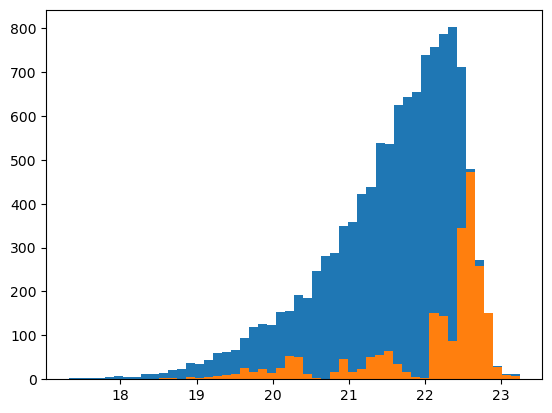

In [232]:
gcs = predictions[predictions['pred']=='gc']
gcs_44 = gcs#[(gcs['g']+gcs['i']<44) & (gcs['g']+gcs['i'] > 30)]

plt.hist(predictions['i'],bins=50)
plt.hist(gcs['i'],bins=50)

plt.show()


### Test

In [29]:
training_data_MAIN = pickle.load(open(f'./pickle/training_data/{train_files[0]}','rb'))

training_data = training_data_MAIN[300]

test_data = training_data[training_data['di']+training_data['dg'] < 0.1][training_data['class'] != 'star']

test_gcs = test_data[test_data['class'] == 'gc']

test_data

C:\Users\jwarn\AppData\Local\Temp\ipykernel_16988\1346209107.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = training_data[training_data['di']+training_data['dg'] < 0.1][training_data['class'] != 'star']


,obj_id,class,i,g,di,dg,ra,dec,field,pdidx
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860
...,...,...,...,...,...,...,...,...,...,...
2288,FJJ-VIII,gc,17.910999,18.806000,0.001,0.001,9.848991,48.312565,398,168456
2289,FJJ-IV,gc,18.417999,19.346001,0.002,0.002,9.801158,48.380100,398,168491
2290,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376
2291,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423


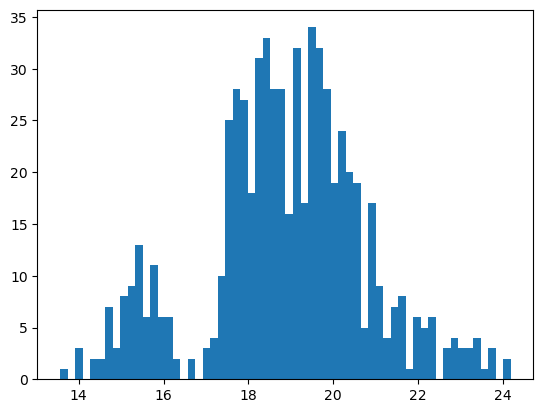

In [32]:
plt.hist(test_gcs['g'],bins=60)
plt.show()

In [ ]:
results = []
for 

In [ ]:
results = []
for file_name in train_files:
    training_data = pickle.load(open(f'./pickle/training_data/{file_name}','rb'))
    test_data = pickle.load(open(f'./pickle/{cat_files[3]}','rb'))[184] # field 184
    results.append(ranfor(training_data[250]).predict(test_data))

In [43]:
CAT = load_cat(188)

In [68]:
cat = CAT[188]

In [79]:
cat_smalldelta = cat[cat['dg']+cat['di'] < 0.1]

In [80]:
X = cat_smalldelta[['i','g']]

In [81]:
X = X.to_pandas()

In [82]:
X

,i,g
0,13.206000,13.678000
1,13.272000,13.694000
2,13.528000,13.924000
3,13.246000,13.950000
4,13.625000,13.929000
...,...,...
53345,21.943001,24.875999
53346,21.957001,24.913000
53347,21.662001,24.964001
53348,21.547001,24.981001


In [125]:
f = ['training_data_d006.pk','training_data_d005.pk','training_data_d004.pk','training_data_d003.pk']

In [126]:
training_data = pickle.load(open(f'./pickle/training_data/{f[1]}','rb'))

In [93]:
test_results = ranfor(test_, n_estimators=70, stats=True)

In [95]:
predictions188 = ranfor(test_, n_estimators=60).predict(X)

In [94]:
test_results[2] # yay!

0.8382352941176471

In [105]:
cat_smalldelta['pred'] = predictions188

In [100]:
cat395_pred = cat[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [101]:
cat395_pred['pred'] = res

In [103]:
with open('./pickle/ml_results/field395_predictions.pk','wb') as f:
    pickle.dump(cat395_pred,f)

In [84]:
test_ = pickle.load(open('./pickle/ml_results/field273_predictions.pk','rb'))

In [128]:
cat188_pred = cat[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [129]:
cat188_pred['pred'] = res

In [130]:
with open('./pickle/ml_results/field188_predictions.pk','wb') as f:
    pickle.dump(cat188_pred,f)

In [115]:
cat24_pred = cat24[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [116]:
cat24_pred['pred'] = res

In [117]:
with open('./pickle/ml_results/field24_predictions.pk','wb') as f:
    pickle.dump(cat24_pred,f)

In [53]:
# iterate to find best values
crowding_test_values = [300,275,250,225,200,175,150,125,100,75,50]
trees = [10,25,50,60,80,120]
accuracies = {}
iterations = 3

for m in object_match_files:
    obj_mat = pickle.load(open(f'./pickle/matches/{m}','rb'))
    accuracies[m[-4:-3]] = []
    for c in trees:#crowding_test_values:
        acc_t = 0 # total accuracy sum
        for i in range(iterations):
            t1 = time()
            #training_data, _ = generate_training_data(obj_mat, crowding=250) #stupid!
            _, __, acc = ranfor(training_data, n_estimators=c)
            acc_t += acc
            t2 = time()
            print(t2-t1)
        acc_t /= iterations
        accuracies[m[-4:-3]].append(acc_t)
        print(f'crowding: {c}, accuracy: {acc_t}')
        

59.16055750846863
55.01980996131897
53.677734375
crowding: 300, accuracy: 0.6144170295113692
51.2863883972168
54.201602935791016
66.1094582080841
crowding: 275, accuracy: 0.6368604073522107
77.24949383735657
71.25472140312195
73.84445881843567
crowding: 250, accuracy: 0.60671834625323
67.04550671577454
55.90899848937988
55.41255736351013
crowding: 225, accuracy: 0.6017094017094017
52.776262044906616
52.33641076087952


KeyboardInterrupt: 

In [ ]:
with open('./pickle/ml_results/accuracies_d00654_300-50--25.pk','wb') as f:
    pickle.dump(accuracies,f)

In [ ]:
#d005
plt.plot(crowding_test_values, accuracies[4], 'g')
plt.plot(crowding_test_values, accuracies[5], 'b')
plt.plot(crowding_test_values, accuracies[6], 'r')

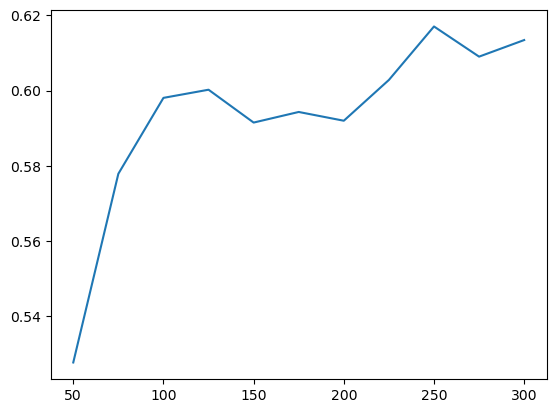

In [39]:
#d006
plt.plot(crowding_test_values, accuracies)